## EZ Coin Crypto Data Prep

In [2]:
# Import libraries and dependencies
import ccxt
import os
import pandas as pd
from dotenv import load_dotenv
import talib
from matplotlib import pyplot as plt

import numpy as np
import time
import datetime

ModuleNotFoundError: ignored

In [9]:
#Google Colab install commands
#!pip install ccxt
#!pip install python-dotenv
#!pip install jupyter-dash

# url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
# !wget $url/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
# !wget $url/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
# !dpkg -i libta.deb ta.deb
# !pip install ta-lib


In [10]:
#Training Start: 12/1/2020
#Training Start: 02/17/2021
#Training Start: 02/18/2021
#Training Start: 03/22/2021

In [11]:
#@title Cryptocurrency Selector
# user input for cyrpto coin
# user input for period

select_crypto = 'ETH' #@param ["BTC", "ETH", "XRP","ADA", "DOT", "CRO"]
select_period = '1d' #@param ["1m", "5m", "30m","1h", "1d", "1w"]

print(select_crypto)
print(select_period)


ETH
1d


In [12]:
# Load environment variables
load_dotenv()
curr = '/USD'
symbol = select_crypto  + curr
period = select_period
limit = 150

# Import environment variables
kraken_public_key = os.getenv("KRAKEN_PUBLIC_KEY")
kraken_secret_key = os.getenv("KRAKEN_SECRET_KEY")
kraken = ccxt.kraken({"apiKey": kraken_public_key, "secret": kraken_secret_key})

# Verify that environment variables were loaded
print(f"Kraken key data type: {type(kraken_public_key)}")
print(f"Kraken secren data type: {type(kraken_secret_key)}")

Kraken key data type: <class 'str'>
Kraken secren data type: <class 'str'>


In [13]:
# function to pull crypto data
def fetch_crypto_data(crypto, interval, limit):
    interval_in_min = {'1m':1,'5m':5, '30m':30, '1h':60, '1d':1440, '1w':10080}
    no_of_data = limit * interval_in_min[interval]
    print(no_of_data)
    past_datetime = (datetime.datetime.now() + datetime.timedelta(minutes=240-no_of_data)).strftime('%Y-%m-%d %H:%M:%S')
    data = kraken.fetch_ohlcv(crypto, interval, kraken.parse8601(past_datetime))
    time.sleep(1)
    return data

In [14]:
data = fetch_crypto_data(symbol, period, limit)
df_kraken = pd.DataFrame(data, columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
#df_kraken['date'] = pd.to_datetime(df_kraken['date'],unit='ms')

# Set index as datetime object and drop extraneous columns
df_kraken.set_index(pd.to_datetime(df_kraken['Date'], unit='ms', infer_datetime_format=True), inplace=True)
df_kraken.drop(columns=['Date'], inplace=True)


216000


In [15]:
df_kraken

,Open,High,Low,Close,Volume
Date,,,,,
2020-10-24,409.65,416.61,407.55,412.38,18458.140313
2020-10-25,412.41,417.84,403.25,406.35,27190.693068
2020-10-26,406.22,411.31,382.80,393.48,73020.457930
2020-10-27,393.48,410.48,390.52,403.65,39937.762229
2020-10-28,403.55,409.18,381.10,388.63,53447.351942
...,...,...,...,...,...
2021-03-18,1824.40,1849.00,1759.79,1776.57,44571.048795
2021-03-19,1776.57,1839.98,1731.40,1810.38,39611.810869
2021-03-20,1810.38,1868.48,1801.38,1805.00,33257.714002


In [16]:
# Drop NAs and calculate daily percent return
df_kraken['daily_return'] = df_kraken['Close'].dropna().pct_change()
df_kraken

,Open,High,Low,Close,Volume,daily_return
Date,,,,,,
2020-10-24,409.65,416.61,407.55,412.38,18458.140313,NaN
2020-10-25,412.41,417.84,403.25,406.35,27190.693068,-0.014622
2020-10-26,406.22,411.31,382.80,393.48,73020.457930,-0.031672
2020-10-27,393.48,410.48,390.52,403.65,39937.762229,0.025846
2020-10-28,403.55,409.18,381.10,388.63,53447.351942,-0.037210
...,...,...,...,...,...,...
2021-03-18,1824.40,1849.00,1759.79,1776.57,44571.048795,-0.025875
2021-03-19,1776.57,1839.98,1731.40,1810.38,39611.810869,0.019031
2021-03-20,1810.38,1868.48,1801.38,1805.00,33257.714002,-0.002972


In [17]:
# Set short and long windows
short_window = 1
long_window = 10

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
df_kraken['fast_close'] = df_kraken['Close'].ewm(halflife=short_window).mean()
df_kraken['slow_close'] = df_kraken['Close'].ewm(halflife=long_window).mean()

# Construct a crossover trading signal
df_kraken['crossover_long'] = np.where(df_kraken['fast_close'] > df_kraken['slow_close'], 1.0, 0.0)
df_kraken['crossover_short'] = np.where(df_kraken['fast_close'] < df_kraken['slow_close'], -1.0, 0.0)
df_kraken['crossover_signal'] = df_kraken['crossover_long'] + df_kraken['crossover_short']

df_kraken.head()

,Open,High,Low,Close,Volume,daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal
Date,,,,,,,,,,,
2020-10-24,409.65,416.61,407.55,412.38,18458.140313,NaN,412.380000,412.380000,0.0,0.0,0.0
2020-10-25,412.41,417.84,403.25,406.35,27190.693068,-0.014622,408.360000,409.260550,0.0,-1.0,-1.0
2020-10-26,406.22,411.31,382.80,393.48,73020.457930,-0.031672,399.857143,403.631843,0.0,-1.0,-1.0
2020-10-27,393.48,410.48,390.52,403.65,39937.762229,0.025846,401.880000,403.636865,0.0,-1.0,-1.0
2020-10-28,403.55,409.18,381.10,388.63,53447.351942,-0.037210,395.041290,400.205700,0.0,-1.0,-1.0


In [ ]:
# Plot the EMA of ETH/USD closing prices
df_kraken[['Close', 'fast_close', 'slow_close']].plot(figsize=(20,10))

In [19]:
# Set short and long volatility windows
short_vol_window = 1
long_vol_window = 10

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
df_kraken['fast_vol'] = df_kraken['daily_return'].ewm(halflife=short_vol_window).std()
df_kraken['slow_vol'] = df_kraken['daily_return'].ewm(halflife=long_vol_window).std()

# Construct a crossover trading signal
df_kraken['vol_trend_long'] = np.where(df_kraken['fast_vol'] < df_kraken['slow_vol'], 1.0, 0.0)
df_kraken['vol_trend_short'] = np.where(df_kraken['fast_vol'] > df_kraken['slow_vol'], -1.0, 0.0) 
df_kraken['vol_trend_signal'] = df_kraken['vol_trend_long'] + df_kraken['vol_trend_short']

df_kraken

,Open,High,Low,Close,Volume,daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal
Date,,,,,,,,,,,,,,,,
2020-10-24,409.65,416.61,407.55,412.38,18458.140313,NaN,412.380000,412.380000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
2020-10-25,412.41,417.84,403.25,406.35,27190.693068,-0.014622,408.360000,409.260550,0.0,-1.0,-1.0,NaN,NaN,0.0,0.0,0.0
2020-10-26,406.22,411.31,382.80,393.48,73020.457930,-0.031672,399.857143,403.631843,0.0,-1.0,-1.0,0.012056,0.012056,0.0,0.0,0.0
2020-10-27,393.48,410.48,390.52,403.65,39937.762229,0.025846,401.880000,403.636865,0.0,-1.0,-1.0,0.034641,0.030128,0.0,-1.0,-1.0
2020-10-28,403.55,409.18,381.10,388.63,53447.351942,-0.037210,395.041290,400.205700,0.0,-1.0,-1.0,0.034373,0.029096,0.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-18,1824.40,1849.00,1759.79,1776.57,44571.048795,-0.025875,1797.673627,1718.917058,1.0,0.0,1.0,0.026545,0.048168,1.0,0.0,1.0
2021-03-19,1776.57,1839.98,1731.40,1810.38,39611.810869,0.019031,1804.026813,1725.042287,1.0,0.0,1.0,0.026447,0.046684,1.0,0.0,1.0
2021-03-20,1810.38,1868.48,1801.38,1805.00,33257.714002,-0.002972,1804.513407,1730.397004,1.0,0.0,1.0,0.019158,0.045139,1.0,0.0,1.0


In [ ]:
# Plot the EMA of BTC/USD daily return volatility
df_kraken[['fast_vol', 'slow_vol']].plot(figsize=(20,10))

In [21]:
# Set bollinger band window
bollinger_window = 10

# Calculate rolling mean and standard deviation
df_kraken['bollinger_mid_band'] = df_kraken['Close'].rolling(window=bollinger_window).mean()
df_kraken['bollinger_std'] = df_kraken['Close'].rolling(window=20).std()

# Calculate upper and lowers bands of bollinger band
df_kraken['bollinger_upper_band']  = df_kraken['bollinger_mid_band'] + (df_kraken['bollinger_std'] * 1)
df_kraken['bollinger_lower_band']  = df_kraken['bollinger_mid_band'] - (df_kraken['bollinger_std'] * 1)

# Calculate bollinger band trading signal
df_kraken['bollinger_long'] = np.where(df_kraken['Close'] < df_kraken['bollinger_lower_band'], 1.0, 0.0)
df_kraken['bollinger_short'] = np.where(df_kraken['Close'] > df_kraken['bollinger_upper_band'], -1.0, 0.0)
df_kraken['bollinger_signal'] = df_kraken['bollinger_long'] + df_kraken['bollinger_short']

df_kraken

,Open,High,Low,Close,Volume,daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
Date,,,,,,,,,,,,,,,,,,,,,,,
2020-10-24,409.65,416.61,407.55,412.38,18458.140313,NaN,412.380000,412.380000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2020-10-25,412.41,417.84,403.25,406.35,27190.693068,-0.014622,408.360000,409.260550,0.0,-1.0,-1.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2020-10-26,406.22,411.31,382.80,393.48,73020.457930,-0.031672,399.857143,403.631843,0.0,-1.0,-1.0,0.012056,0.012056,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2020-10-27,393.48,410.48,390.52,403.65,39937.762229,0.025846,401.880000,403.636865,0.0,-1.0,-1.0,0.034641,0.030128,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2020-10-28,403.55,409.18,381.10,388.63,53447.351942,-0.037210,395.041290,400.205700,0.0,-1.0,-1.0,0.034373,0.029096,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-18,1824.40,1849.00,1759.79,1776.57,44571.048795,-0.025875,1797.673627,1718.917058,1.0,0.0,1.0,0.026545,0.048168,1.0,0.0,1.0,1822.873,155.740402,1978.613402,1667.132598,0.0,0.0,0.0
2021-03-19,1776.57,1839.98,1731.40,1810.38,39611.810869,0.019031,1804.026813,1725.042287,1.0,0.0,1.0,0.026447,0.046684,1.0,0.0,1.0,1816.677,146.681127,1963.358127,1669.995873,0.0,0.0,0.0
2021-03-20,1810.38,1868.48,1801.38,1805.00,33257.714002,-0.002972,1804.513407,1730.397004,1.0,0.0,1.0,0.019158,0.045139,1.0,0.0,1.0,1817.598,130.102136,1947.700136,1687.495864,0.0,0.0,0.0


In [ ]:
# Plot the Bollinger Bands for BTC/USD closing prices
df_kraken[['Close','bollinger_mid_band','bollinger_upper_band','bollinger_lower_band']].plot(figsize=(20,10))

In [23]:
# Define RSI indicator
df_kraken['RSI'] = talib.RSI(df_kraken["Close"])
rsi_overbought = np.where( df_kraken['RSI'] <30, 1.0, 0.0)  #oversold would indicate buy
rsi_oversold = np.where( df_kraken['RSI'] >70, -1.0, 0.0) #overbought would indicate sell
rsi_signal = rsi_overbought + rsi_oversold
df_kraken['RSI_signal'] = rsi_signal

In [24]:
df_kraken

,Open,High,Low,Close,Volume,daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,RSI,RSI_signal
Date,,,,,,,,,,,,,,,,,,,,,,,,,
2020-10-24,409.65,416.61,407.55,412.38,18458.140313,NaN,412.380000,412.380000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0
2020-10-25,412.41,417.84,403.25,406.35,27190.693068,-0.014622,408.360000,409.260550,0.0,-1.0,-1.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0
2020-10-26,406.22,411.31,382.80,393.48,73020.457930,-0.031672,399.857143,403.631843,0.0,-1.0,-1.0,0.012056,0.012056,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0
2020-10-27,393.48,410.48,390.52,403.65,39937.762229,0.025846,401.880000,403.636865,0.0,-1.0,-1.0,0.034641,0.030128,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0
2020-10-28,403.55,409.18,381.10,388.63,53447.351942,-0.037210,395.041290,400.205700,0.0,-1.0,-1.0,0.034373,0.029096,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-18,1824.40,1849.00,1759.79,1776.57,44571.048795,-0.025875,1797.673627,1718.917058,1.0,0.0,1.0,0.026545,0.048168,1.0,0.0,1.0,1822.873,155.740402,1978.613402,1667.132598,0.0,0.0,0.0,53.096861,0.0
2021-03-19,1776.57,1839.98,1731.40,1810.38,39611.810869,0.019031,1804.026813,1725.042287,1.0,0.0,1.0,0.026447,0.046684,1.0,0.0,1.0,1816.677,146.681127,1963.358127,1669.995873,0.0,0.0,0.0,54.964400,0.0
2021-03-20,1810.38,1868.48,1801.38,1805.00,33257.714002,-0.002972,1804.513407,1730.397004,1.0,0.0,1.0,0.019158,0.045139,1.0,0.0,1.0,1817.598,130.102136,1947.700136,1687.495864,0.0,0.0,0.0,54.591907,0.0


In [ ]:
fig = plt.figure()
fig.set_size_inches((25, 18))
ax_rsi = fig.add_axes((0, 0.24, 1, 0.2))
ax_rsi.plot(df_kraken.index, [70] * len(df_kraken.index), label="overbought")
ax_rsi.plot(df_kraken.index, [30] * len(df_kraken.index), label="oversold")
ax_rsi.plot(df_kraken.index, df_kraken['RSI'], label="rsi")
ax_rsi.plot(df_kraken["RSI"])
ax_rsi.legend()

In [26]:
# Set x variable list of features
x_var_list = ['crossover_signal', 'vol_trend_signal', 'bollinger_signal', 'RSI_signal']
df_kraken[x_var_list] = df_kraken[x_var_list].shift(1)
df_kraken[x_var_list].tail()

,crossover_signal,vol_trend_signal,bollinger_signal,RSI_signal
Date,,,,
2021-03-18,1.0,1.0,0.0,0.0
2021-03-19,1.0,1.0,0.0,0.0
2021-03-20,1.0,1.0,0.0,0.0
2021-03-21,1.0,1.0,0.0,0.0
2021-03-22,1.0,1.0,0.0,0.0


In [27]:
# Drop NAs and replace positive/negative infinity values
df_kraken.dropna(inplace=True)
df_kraken.dropna(subset=['daily_return'], inplace=True)
df_kraken = df_kraken.replace([np.inf, -np.inf], np.nan)

#populate Positive Return based on Daily Return
df_kraken['Positive Return'] = np.where(df_kraken['daily_return'] > 0, 1.0, 0.0)

In [28]:
# Construct training start and end dates
training_start = df_kraken.index.min().strftime(format= '%Y-%m-%d')
training_end = '2020-08-20'

# Construct testing start and end dates
testing_start =  '2020-08-21'
testing_end = df_kraken.index.max().strftime(format= '%Y-%m-%d')

# Construct the X_train and y_train datasets
X_train = df_kraken[x_var_list][training_start:training_end]
y_train = df_kraken['Positive Return'][training_start:training_end]

# Construct the X test and y test datasets
X_test = df_kraken[x_var_list][testing_start:testing_end]
y_test = df_kraken['Positive Return'][testing_start:testing_end]

In [29]:
df_kraken.to_csv('kraken_pull_EthExample_03212021.csv')

In [46]:
# Load DataFrame for Dashboard
df_dashboard = df_kraken

## EZ Coin Dashboard

In [1]:
#Import Libriaries
import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.express as px
import plotly.graph_objects as go
from jupyter_dash import JupyterDash
from dash.dependencies import Input, Output

ModuleNotFoundError: ignored

# Load PNG Images files

In [ ]:
#Load image header for dashboard
from PIL import Image; 
img = Image.open('/content/drive/MyDrive/Proj2_Images/EZCoinBlack.png')

# Create figure
figimg = go.Figure()

# Constants
img_width = 2000
img_height = 1000
scale_factor = 0.5

# Add invisible scatter trace.
# This trace is added to help the autoresize logic work.
figimg.add_trace(
    go.Scatter(
        x=[0, img_width * scale_factor],
        y=[0, img_height * scale_factor],
        mode="markers",
        marker_opacity=0
    )
)

# Configure axes
figimg.update_xaxes(
    visible=False,
    range=[0, img_width * scale_factor]
)

figimg.update_yaxes(
    visible=False,
    range=[0, img_height * scale_factor],
    # the scaleanchor attribute ensures that the aspect ratio stays constant
    scaleanchor="x"
)

# Add image
figimg.add_layout_image(
    dict(
        x=0,
        sizex=img_width * scale_factor,
        y=img_height * scale_factor,
        sizey=img_height * scale_factor,
        xref="x",
        yref="y",
        opacity=1.0,
        layer="below",
        sizing="stretch",
        source=img)
)

# Configure other layout
figimg.update_layout(
    width=img_width * scale_factor,
    height=img_height * scale_factor,
    margin={"l": 0, "r": 0, "t": 0, "b": 0},
)

# Disable the autosize on double click because it adds unwanted margins around the image
figimg.show(config={'doubleClick': 'reset'})


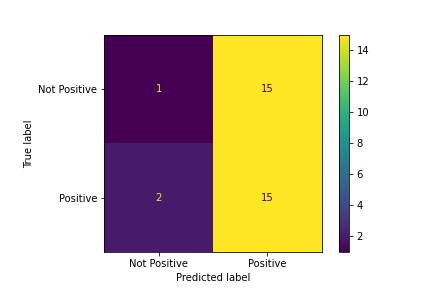


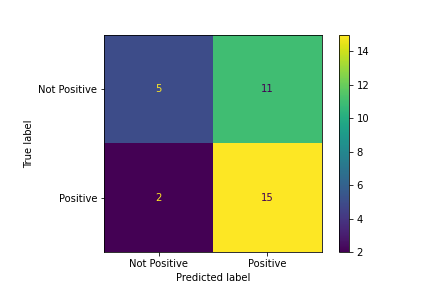

In [186]:
#Load confusion matrix png files for dashboard
img_rfcm = Image.open('/content/drive/MyDrive/Proj2_Images/RF_confusion_matrix.png')
img_abcm = Image.open('/content/drive/MyDrive/Proj2_Images/AB_confusion_matrix.png')

# Create figure for Random Forest Confusion Matrix
figimg_rfcm = go.Figure()

# Constants
img_width = 1600
img_height = 900
scale_factor = 0.5

# Add invisible scatter trace.
# This trace is added to help the autoresize logic work.
figimg_rfcm.add_trace(
    go.Scatter(
        x=[0, img_width * scale_factor],
        y=[0, img_height * scale_factor],
        mode="markers",
        marker_opacity=0
    )
)

# Configure axes
figimg_rfcm.update_xaxes(
    visible=False,
    range=[0, img_width * scale_factor]
)

figimg_rfcm.update_yaxes(
    visible=False,
    range=[0, img_height * scale_factor],
    # the scaleanchor attribute ensures that the aspect ratio stays constant
    scaleanchor="x"
)

# Add image
figimg_rfcm.add_layout_image(
    dict(
        x=0,
        sizex=img_width * scale_factor,
        y=img_height * scale_factor,
        sizey=img_height * scale_factor,
        xref="x",
        yref="y",
        opacity=1.0,
        layer="below",
        sizing="stretch",
        source=img_rfcm)
)

# Configure other layout
figimg_rfcm.update_layout(
    width=img_width * scale_factor,
    height=img_height * scale_factor,
    margin={"l": 0, "r": 0, "t": 0, "b": 0},
)

# Create figure for AdaBoost Confusion Matrix
figimg_abcm = go.Figure()


# Add invisible scatter trace.
# This trace is added to help the autoresize logic work.
figimg_abcm.add_trace(
    go.Scatter(
        x=[0, img_width * scale_factor],
        y=[0, img_height * scale_factor],
        mode="markers",
        marker_opacity=0
    )
)

# Configure axes
figimg_abcm.update_xaxes(
    visible=False,
    range=[0, img_width * scale_factor]
)

figimg_abcm.update_yaxes(
    visible=False,
    range=[0, img_height * scale_factor],
    # the scaleanchor attribute ensures that the aspect ratio stays constant
    scaleanchor="x"
)

# Add image
figimg_abcm.add_layout_image(
    dict(
        x=0,
        sizex=img_width * scale_factor,
        y=img_height * scale_factor,
        sizey=img_height * scale_factor,
        xref="x",
        yref="y",
        opacity=1.0,
        layer="below",
        sizing="stretch",
        source=img_abcm)
)

# Configure other layout
figimg_abcm.update_layout(
    width=img_width * scale_factor,
    height=img_height * scale_factor,
    margin={"l": 0, "r": 0, "t": 0, "b": 0},
)

# Disable the autosize on double click because it adds unwanted margins around the image
# More detail: https://plotly.com/python/configuration-options/
figimg_rfcm.show(config={'doubleClick': 'reset'})
figimg_abcm.show(config={'doubleClick': 'reset'})

In [ ]:
#Load Model Results png files for dashboard
img_rf = Image.open('/content/drive/MyDrive/Proj2_Images/RF_results_combined.png')
img_ab = Image.open('/content/drive/MyDrive/Proj2_Images/AB_results_combined.png')

# Create figure for Random Forest results
figimg_rf = go.Figure()

# Constants
img_width = 1600
img_height = 900
scale_factor = 0.5

# Add invisible scatter trace.
# This trace is added to help the autoresize logic work.
figimg_rf.add_trace(
    go.Scatter(
        x=[0, img_width * scale_factor],
        y=[0, img_height * scale_factor],
        mode="markers",
        marker_opacity=0
    )
)

# Configure axes
figimg_rf.update_xaxes(
    visible=False,
    range=[0, img_width * scale_factor]
)

figimg_rf.update_yaxes(
    visible=False,
    range=[0, img_height * scale_factor],
    # the scaleanchor attribute ensures that the aspect ratio stays constant
    scaleanchor="x"
)

# Add image
figimg_rf.add_layout_image(
    dict(
        x=0,
        sizex=img_width * scale_factor,
        y=img_height * scale_factor,
        sizey=img_height * scale_factor,
        xref="x",
        yref="y",
        opacity=1.0,
        layer="below",
        sizing="stretch",
        source=img_rf)
)

# Configure other layout
figimg_rf.update_layout(
    width=img_width * scale_factor,
    height=img_height * scale_factor,
    margin={"l": 0, "r": 0, "t": 0, "b": 0},
)

# Create figure for AdaBoost results
figimg_ab = go.Figure()


# Add invisible scatter trace.
# This trace is added to help the autoresize logic work.
figimg_ab.add_trace(
    go.Scatter(
        x=[0, img_width * scale_factor],
        y=[0, img_height * scale_factor],
        mode="markers",
        marker_opacity=0
    )
)

# Configure axes
figimg_ab.update_xaxes(
    visible=False,
    range=[0, img_width * scale_factor]
)

figimg_ab.update_yaxes(
    visible=False,
    range=[0, img_height * scale_factor],
    # the scaleanchor attribute ensures that the aspect ratio stays constant
    scaleanchor="x"
)

# Add image
figimg_ab.add_layout_image(
    dict(
        x=0,
        sizex=img_width * scale_factor,
        y=img_height * scale_factor,
        sizey=img_height * scale_factor,
        xref="x",
        yref="y",
        opacity=1.0,
        layer="below",
        sizing="stretch",
        source=img_ab)
)

# Configure other layout
figimg_ab.update_layout(
    width=img_width * scale_factor,
    height=img_height * scale_factor,
    margin={"l": 0, "r": 0, "t": 0, "b": 0},
)

# Disable the autosize on double click because it adds unwanted margins around the image
# More detail: https://plotly.com/python/configuration-options/
figimg_rf.show(config={'doubleClick': 'reset'})
figimg_ab.show(config={'doubleClick': 'reset'})

In [ ]:
#Load Model PR Curves
img_rfcurve = Image.open('/content/drive/MyDrive/Proj2_Images/RF_PR_Curve.png')
img_abcurve = Image.open('/content/drive/MyDrive/Proj2_Images/AB_PR_Curve.png')

# Create figure for Random Forest results
figimg_rfcurve = go.Figure()

# Constants
img_width = 1600
img_height = 900
scale_factor = 0.5

# Add invisible scatter trace.
# This trace is added to help the autoresize logic work.
figimg_rfcurve.add_trace(
    go.Scatter(
        x=[0, img_width * scale_factor],
        y=[0, img_height * scale_factor],
        mode="markers",
        marker_opacity=0
    )
)

# Configure axes
figimg_rfcurve.update_xaxes(
    visible=False,
    range=[0, img_width * scale_factor]
)

figimg_rfcurve.update_yaxes(
    visible=False,
    range=[0, img_height * scale_factor],
    # the scaleanchor attribute ensures that the aspect ratio stays constant
    scaleanchor="x"
)

# Add image
figimg_rfcurve.add_layout_image(
    dict(
        x=0,
        sizex=img_width * scale_factor,
        y=img_height * scale_factor,
        sizey=img_height * scale_factor,
        xref="x",
        yref="y",
        opacity=1.0,
        layer="below",
        sizing="stretch",
        source=img_rfcurve)
)

# Configure other layout
figimg_rfcurve.update_layout(
    width=img_width * scale_factor,
    height=img_height * scale_factor,
    margin={"l": 0, "r": 0, "t": 0, "b": 0},
)

# Create figure for AdaBoost results
figimg_abcurve = go.Figure()


# Add invisible scatter trace.
# This trace is added to help the autoresize logic work.
figimg_abcurve.add_trace(
    go.Scatter(
        x=[0, img_width * scale_factor],
        y=[0, img_height * scale_factor],
        mode="markers",
        marker_opacity=0
    )
)

# Configure axes
figimg_abcurve.update_xaxes(
    visible=False,
    range=[0, img_width * scale_factor]
)

figimg_abcurve.update_yaxes(
    visible=False,
    range=[0, img_height * scale_factor],
    # the scaleanchor attribute ensures that the aspect ratio stays constant
    scaleanchor="x"
)

# Add image
figimg_abcurve.add_layout_image(
    dict(
        x=0,
        sizex=img_width * scale_factor,
        y=img_height * scale_factor,
        sizey=img_height * scale_factor,
        xref="x",
        yref="y",
        opacity=1.0,
        layer="below",
        sizing="stretch",
        source=img_abcurve)
)

# Configure other layout
figimg_abcurve.update_layout(
    width=img_width * scale_factor,
    height=img_height * scale_factor,
    margin={"l": 0, "r": 0, "t": 0, "b": 0},
)

# Disable the autosize on double click because it adds unwanted margins around the image
# More detail: https://plotly.com/python/configuration-options/
figimg_rfcurve.show(config={'doubleClick': 'reset'})
figimg_abcurve.show(config={'doubleClick': 'reset'})

# Create Technical Indicator Charts

In [ ]:
#EMA of ETH/USD closing prices
fig = go.Figure([
    
    go.Scatter(
        name='Close',
        x=df_dashboard.index,
        y=df_dashboard['Close'],
        mode='markers+lines',
        marker=dict(color='#121cb0'),
        line=dict(width=3),
        showlegend=True
    ),
    go.Scatter(
        name='Fast Close',
        x=df_dashboard.index,
        y=df_dashboard['fast_close'],
        mode='lines',
        marker=dict(color="Orange"),
        line=dict(width=1),
        showlegend=True
    ),
    go.Scatter(
        name='Slow Close',
        x=df_dashboard.index,
        y=df_dashboard['slow_close'],
        marker=dict(color="Green"),
        line=dict(width=1),
        mode='lines',
        showlegend=True
    )
    
])
fig.update_layout(
    yaxis_title='Price',
    #title='EMA of ETH/USD closing prices',
    template = 'plotly_dark',
    hovermode="x"
)

In [ ]:
# Plot the EMA of BTC/USD daily return volatility
fig2 = go.Figure([
    
    go.Scatter(
        name='Fast Volume Moving Average',
        x=df_dashboard.index,
        y=df_dashboard['fast_vol'],
        mode='lines',
        marker=dict(color="Orange"),
        line=dict(width=2),
        showlegend=True
    ),
    go.Scatter(
        name='Slow Volume Moving Average',
        x=df_dashboard.index,
        y=df_dashboard['slow_vol'],
        marker=dict(color="Green"),
        line=dict(width=2),
        mode='lines',
        showlegend=True
    )
    
])
fig2.update_layout(
    yaxis_title='Daily Return',
    #title='EMA of BTC/USD daily return volatility',
    template = 'plotly_dark',
    hovermode="x"
)

In [ ]:
#Plot the Bollinger Bands for BTC/USD closing prices

fig3 = go.Figure([
                  
  go.Scatter(
        name='Bollinger',
        x=df_dashboard.index,
        y=df_dashboard['Close'],
        mode='lines',
        marker=dict(color="#121cb0"),
        line=dict(width=3),
        showlegend=True    
    ),

    go.Scatter(
        name='Overbought',
        x=df_dashboard.index,
        y=df_dashboard['bollinger_mid_band'],
        marker=dict(color="Orange"),
        line=dict(width=1),
        mode='lines',
        showlegend=True
    ), 

    go.Scatter(
        name='Oversold',
        x=df_dashboard.index,
        y=df_dashboard['bollinger_upper_band'],
        marker=dict(color="Green"),
        line=dict(width=1),
        mode='lines',
        showlegend=True
    ), 

    go.Scatter(
        name='Oversold',
        x=df_dashboard.index,
        y=df_dashboard['bollinger_lower_band'],
        marker=dict(color="Green"),
        line=dict(width=1),
        mode='lines',
        showlegend=True
    )      
    
             
])
fig3.update_layout(
    yaxis_title='Close Price',
    #title='Bollinger Bands',
    template = 'plotly_dark',
    hovermode="x"
)

In [ ]:
#RSI
fig4 = go.Figure([
                  
  go.Scatter(
        name='RSI',
        x=df_dashboard.index,
        y=df_dashboard['RSI'],
        mode='lines',
        marker=dict(color="#121cb0"),
        line=dict(width=3),
        showlegend=True    
    ),

    go.Scatter(
        name='Overbought',
        x=df_dashboard.index,
        y=[70] * len(df_dashboard.index),
        marker=dict(color="Green"),
        line=dict(width=1),
        mode='lines',
        showlegend=True
    ), 

    go.Scatter(
        name='Oversold',
        x=df_dashboard.index,
        y=[30] * len(df_dashboard.index),
        marker=dict(color="Green"),
        line=dict(width=1),
        mode='lines',
        showlegend=True
    )            
])
fig4.update_layout(
    yaxis_title='Close Price',
    #title='RSI',
    template = 'plotly_dark',
    hovermode="x"
)

# Plotly Dash

In [198]:
# Build Dash App
app = JupyterDash(__name__)

colors = {
    'background': '#111111',
    'text': '#7FDBFF'   
}

app.layout = html.Div(style={'backgroundColor': colors['background']}, children=[
                                
    #image
    html.Div(children=[
        dcc.Graph(figure=figimg)
    ], style={'margin-left': '25%'}
    ), 
    #krakken data chart
    html.Div(style={'width':'75%', 'textAlign': 'left', 'color': colors['text']}, children=[
    html.H1("Dash"),
    dcc.Graph(id='line-chart'),
    html.Label([
        "Input Variable",
        dcc.Dropdown(
            id='Close', clearable=False,
            value=df_dashboard.columns[0], options=[
                {'label': a, 'value': a}
                for a in df_dashboard.columns
            ])
    ]),
]),

html.Div(style={'width':'75%', 'textAlign': 'left', 'color': colors['text']}, children=[
    html.H1("Plot the EMA of ETH closing prices"),
    # Plot the Bollinger Bands for BTC/USD closing prices
    dcc.Graph(figure=fig)
]), 

html.Div(style={'width':'75%', 'textAlign': 'left', 'color': colors['text']}, children=[
    html.H1("Plot the EMA of ETH closing prices"),
    # Plot the Bollinger Bands for BTC/USD closing prices
    dcc.Graph(figure=fig2)
]),

html.Div(style={'width':'75%', 'textAlign': 'left', 'color': colors['text']}, children=[
    html.H1("Plot the EMA of ETH closing prices"),
    # Plot the Bollinger Bands for BTC/USD closing prices
    dcc.Graph(figure=fig3)
]),

html.Div(style={'width':'75%', 'textAlign': 'left', 'color': colors['text']}, children=[
    html.H1("RSI - Relative Strength Indicator"),
    # Plot the Bollinger Bands for BTC/USD closing prices
    dcc.Graph(figure=fig4)
]),

#confusion Matrix
html.Div(children=[
    html.Div((
        html.H1("Confusion Matrix Random Forest"),
        dcc.Graph(figure=figimg_rfcm)
        ), style={'display': 'inline-block', 'padding': '25px'}),
    html.Div((
        html.H1("Confusion Matrix AdaBoost"),
        dcc.Graph(figure=figimg_abcm)
        ), style={'display': 'inline-block', 'padding': '25px'}),
], style={'width': '100%', 'display': 'inline-block', 'color': colors['text'] }
),

#Model Results
html.Div(children=[
    html.Div((
        html.H1("Results Random Forest"),
        dcc.Graph(figure=figimg_rf)
        ), style={'display': 'inline-block', 'padding': '25px'}),
    html.Div((
        html.H1("Results AdaBoost"),
        dcc.Graph(figure=figimg_ab)
        ), style={'display': 'inline-block', 'padding': '25px'}),
], style={'width': '100%', 'display': 'inline-block', 'color': colors['text'] }
),

#Model PR Curve
html.Div(children=[
    html.Div((
        html.H1("Results Random Forest"),
        dcc.Graph(figure=figimg_rfcurve)
        ), style={'display': 'inline-block', 'padding': '25px'}),
    html.Div((
        html.H1("Results AdaBoost"),
        dcc.Graph(figure=figimg_abcurve)
        ), style={'display': 'inline-block', 'padding': '25px'}),
], style={'width': '100%', 'display': 'inline-block', 'color': colors['text'] }
)

])
# Define callback to update interactive graph
@app.callback(
    Output('line-chart', 'figure'),
    [Input('Close', "value")]
)
def update_figure(columns):
    return px.line(
        df_dashboard, x=df_dashboard.index, y=columns, template = "plotly_dark",
        render_mode="webgl")

# Run app and display result inline in the notebook
#app.run_server(mode='inline')
app.run_server(mode='external')

Dash app running on:


<IPython.core.display.Javascript object>